In [2]:
import shapely
print(shapely.__version__)


1.7.0


In [3]:
import cv2

In [4]:
import os
os.getcwd()
os.chdir('C:/Users/xiaoxuanliu/Documents/GitHub/CubiCasa5k')
os.listdir()

['.dockerignore',
 '.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'create_lmdb.py',
 'data',
 'Difference in Room Annotation.pdf',
 'Dockerfile',
 'eval.py',
 'floortrans',
 'LICENSE',
 'r.png',
 'README.md',
 'requirements.txt',
 'runs_cubi',
 'samples.ipynb',
 'train.py']

In [5]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation,get_wall_polygon,remove_overlapping_walls
from floortrans.post_prosessing import get_wall_seg
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
#model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
#model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
#model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
#checkpoint = torch.load('model_best_val_loss_var.pkl')

#model.load_state_dict(checkpoint['model_state'])
#model.eval()
#model.cuda()
print("Model loaded.")

Model loaded.


In [6]:
val = next(data_iter)
junctions = val['heatmaps']
#folder = val['folder'][0]
image = val['image']#.cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
#plt.figure(figsize=(10,10))
#plt.title('Source Image', fontsize=20)
#plt.axis('off')
#plt.imshow(np_img)
#plt.show()

In [45]:
label.shape

torch.Size([1, 2, 592, 883])

In [29]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= data_folder+folder+"model.svg", width=800)

In [56]:
label_np = label.data.numpy()[0]
label_np[0].shape
print(592/21)

28.19047619047619


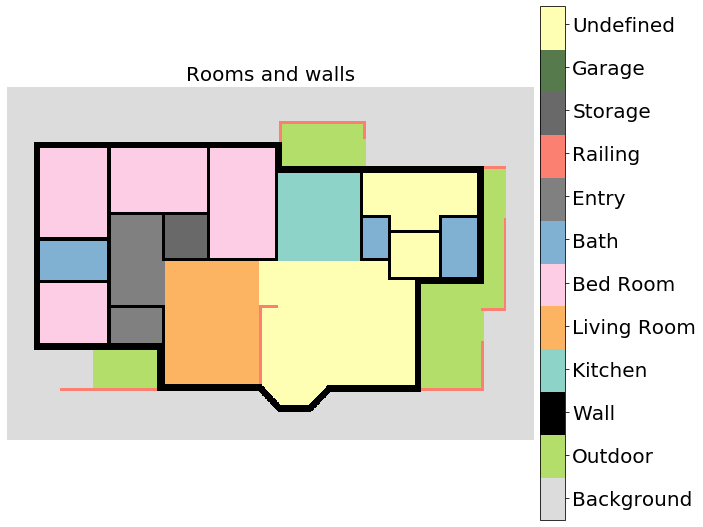

In [7]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

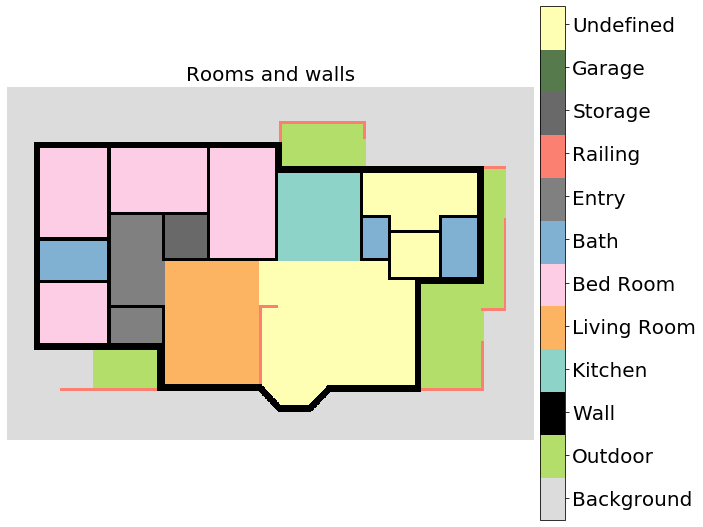

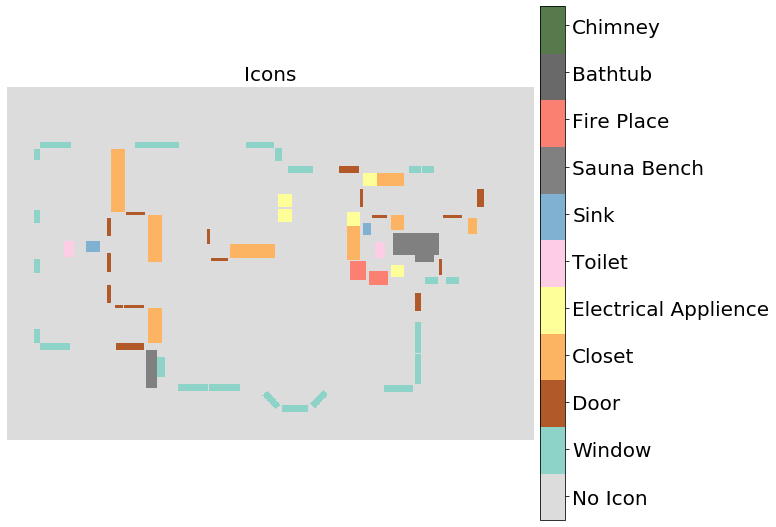

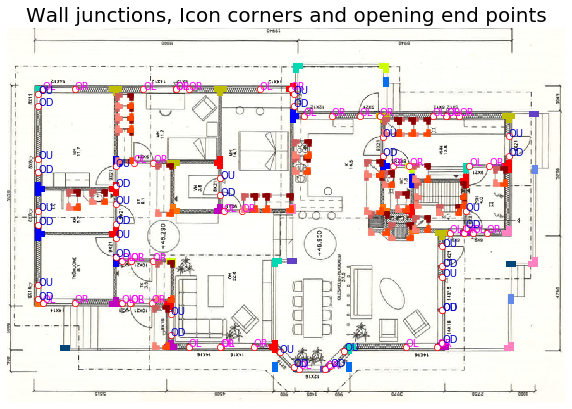

In [8]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

In [12]:
import pickle
import time
import copy
from collections import defaultdict
val_room_dict = defaultdict(int)

normal_set = FloorplanSVG(data_folder, 'val.txt', format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)

start = time.time()
for t,val in enumerate(data_loader):
    label_np = val['label'].data.numpy()[0][0]
    for i in range(12):
        x = copy.copy(label_np)
        x[label_np != i] = 0 
        x = x.astype(np.uint8)
        contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        val_room_dict[i]+=len(contours)
    
    if t%100 == 0: 
        print(t,'finished', time.time() - start)




0 finished 0.2619144916534424
100 finished 66.3872606754303
200 finished 124.01697397232056
300 finished 176.3416886329651


FileNotFoundError: [Errno 2] No such file or directory: './EDA_results/val_rooms.pkl'

In [13]:
import seaborn as sns
with open('./train_rooms.pkl', 'rb') as f:
    train_room_dict = pickle.load(f)
import seaborn as sns
with open('./test_rooms.pkl', 'rb') as f:
    test_room_dict = pickle.load(f)

In [15]:
def seg_counts(polygon = 'room', subset = 'train'):
    with open(f'./{subset}_{polygon}s.pkl', 'rb') as f:
        poly_dict = pickle.load(f)
        
        
    poly_arr = [poly_dict[i] for i in range(len(poly_dict))]
    
    if polygon == 'room':
        
        room_classes_vis = [room_classes[1]]+room_classes[2:]
        poly_arr_vis = [poly_arr[1]]+ poly_arr[2:]
            
        plt.figure(figsize = (10,5))
        plt.bar(x = room_classes_vis, height = poly_arr_vis)
        plt.xticks(rotation = 45)
        plt.title(f'{subset} set room counts')
        plt.xlabel('room types')
        plt.ylabel('counts')
        plt.show()
        
    elif polygon == 'icon':
        
        icon_classes_vis = icon_classes[1:]
        poly_arr_vis =  poly_arr[1:]
        plt.figure(figsize = (10,5))
        plt.bar(x = icon_classes_vis, height = poly_arr_vis)
        plt.xticks(rotation = 45)
        plt.title(f'{subset} set room counts')
        plt.xlabel('icon types')
        plt.ylabel('counts')
        plt.show()

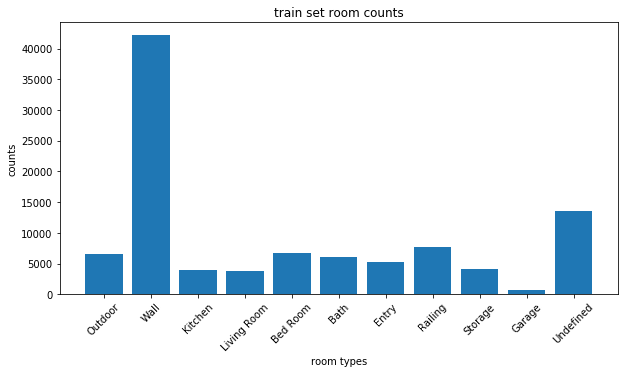

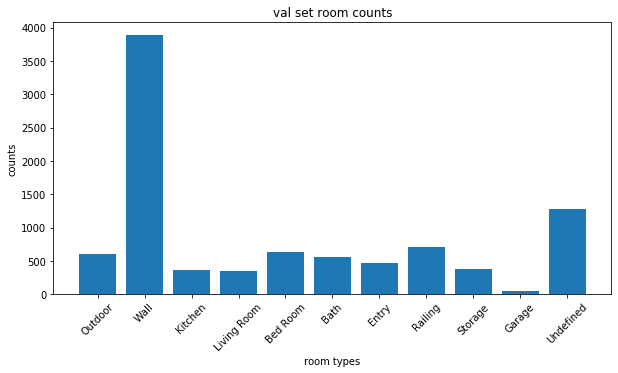

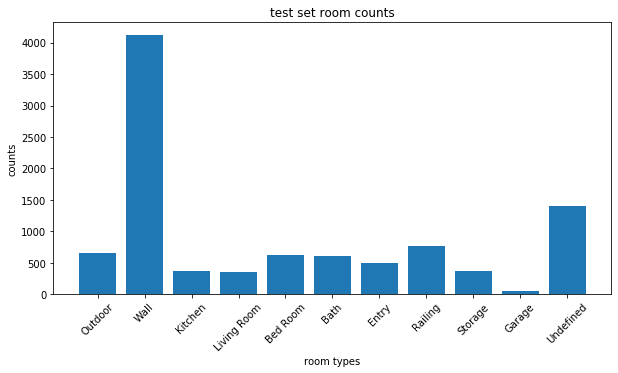

In [16]:

seg_counts('room', 'train')
seg_counts('room', 'val')
seg_counts('room', 'test')

In [23]:
def combine_counts(polygon = 'room', prop = False):
    
    dict_list = []
    poly_arrs = []
    
    for subset in ['train','val','test']:
        with open(f'./{subset}_{polygon}s.pkl', 'rb') as f:
            subset_dict = pickle.load(f)
        dict_list.append(subset_dict)
        if polygon == 'room':
            arr_temp = [subset_dict[i] for i in range(len(subset_dict))]
            arr = [arr_temp[1]]+arr_temp[2:]   
            
        elif polygon == 'icon':
            arr = [subset_dict[i] for i in range(1,len(subset_dict))]
        
        if prop:
            arr = [x/subset_dict[0] for x in arr]
        
        poly_arrs.append(arr)
    if polygon == 'room':
        
        room_classes_vis = [room_classes[1]]+room_classes[2:]
        
        len_data = len(room_classes_vis)
        width = 0.3
            
        plt.figure(figsize = (10,6))
        
        plt.bar(np.arange(len_data), poly_arrs[0], width=width, label = 'train')
        plt.bar(np.arange(len_data)+ width, poly_arrs[1], width=width, label = 'val')
        plt.bar(np.arange(len_data)+ 2*width, poly_arrs[2], width=width, label = 'test')
        
        
        if prop:
            plt.title('dataset avg room counts')
            plt.ylabel('avg counts')
        else:
            plt.title('dataset room counts')
            plt.ylabel('counts')
        
        plt.xlabel('room types')
        
        plt.xticks(np.arange(len_data)+width, room_classes_vis, rotation = 45)
        plt.legend()
        plt.show()
        
    elif polygon == 'icon':
        icon_classes_vis = icon_classes[1:]
        
        len_data = len(icon_classes_vis)
        width = 0.3
            
        plt.figure(figsize = (10,6))
        
        plt.bar(np.arange(len_data), poly_arrs[0], width=width, label = 'train')
        plt.bar(np.arange(len_data)+ width, poly_arrs[1], width=width, label = 'val')
        plt.bar(np.arange(len_data)+ 2*width, poly_arrs[2], width=width, label = 'test')
        
        if prop:
            plt.title('dataset avg icon counts')
            plt.ylabel('avg counts')
        else:
            plt.title('dataset icon counts')
            plt.ylabel('counts')
        
        
        plt.xlabel('icon types')
        plt.xticks(np.arange(len_data)+width, icon_classes_vis, rotation = 45)
        plt.legend()
        plt.show()

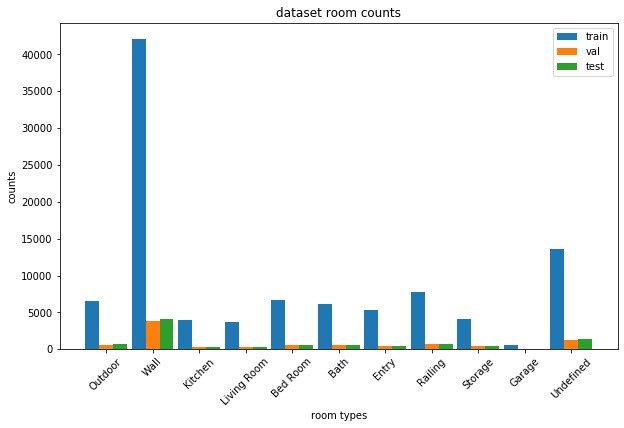

In [24]:
combine_counts('room')

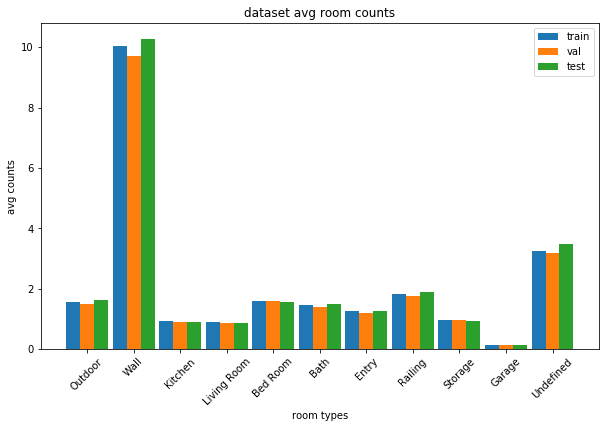

In [25]:
combine_counts('room', True)

In [30]:
def total_counts(polygon = 'room'):
    
    dict_list = []
    poly_arrs = []
    
    for subset in ['train','val','test']:
        with open(f'./{subset}_{polygon}s.pkl', 'rb') as f:
            subset_dict = pickle.load(f)
        dict_list.append(subset_dict)
        if polygon == 'room':
            arr_temp = [subset_dict[i] for i in range(len(subset_dict))]
            arr = [arr_temp[1]]+arr_temp[2:]   
            
        elif polygon == 'icon':
            arr = [subset_dict[i] for i in range(1,len(subset_dict))]
        
        poly_arrs.append(arr)
        
    poly_sums = np.array(poly_arrs).sum(axis = 0)
    
    if polygon == 'room':
        
        room_classes_vis = [room_classes[1]]+room_classes[2:]
            
        plt.figure(figsize = (10,6))
        plt.bar(x = room_classes_vis, height = poly_sums)
        plt.xticks(rotation = 45)
        plt.title('dataset total room counts')
        plt.xlabel('room types')
        plt.ylabel('counts')
        plt.show()
    elif polygon == 'icon':
        
        icon_classes_vis = icon_classes[1:]
        plt.figure(figsize = (10,6))
        plt.bar(x = icon_classes_vis, height = poly_sums)
        plt.xticks(rotation = 45)
        plt.title('dataset total icon counts')
        plt.xlabel('icon types')
        plt.ylabel('counts')
        plt.show()

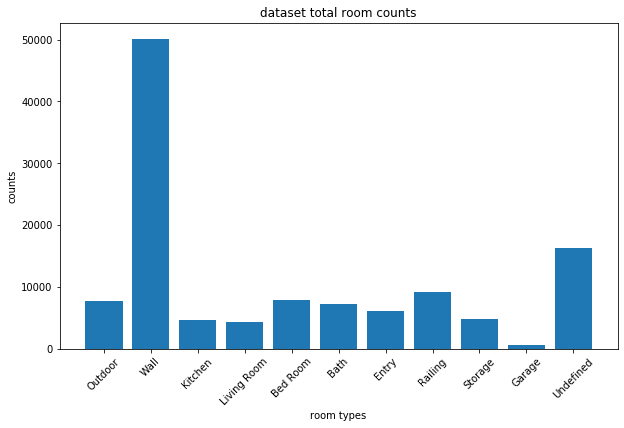

In [31]:
total_counts('room')